# Latitude Banded SIF Hovmoller Plot
---

In [1]:
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from dask.distributed import Client
# client = Client(n_workers=16, dashboard_address=":8889")
# client

Client Scheduler: tcp://127.0.0.1:44573 Dashboard: http://127.0.0.1:8889/status,Cluster Workers: 16 Cores: 64 Memory: 270.51 GB


## Data Processing

In [2]:
def prep_sif(ds):
    """Preprocess a SIF Lite file"""
    
    # Drop unused variables
    variable_list = ["Daily_SIF_740nm", "SIF_Uncertainty_740nm", "Quality_Flag", "Longitude", "Latitude", "Delta_Time"]
    ds = ds[variable_list]
    
    # Apply quality filters
    ds["SIF_plus_3sig"] = ds.Daily_SIF_740nm + 3*ds.SIF_Uncertainty_740nm
    ds = ds.where(ds.Quality_Flag != 2, drop=True)
    ds = ds.where(ds.SIF_plus_3sig > 0, drop=True)

    # Format dataset
    dsnew = xarray.Dataset(
        {
            "sif": (["time"], ds.Daily_SIF_740nm),
        },
        coords={
            "lon": (["time"], ds.Longitude),
            "lat": (["time"], ds.Latitude),
            "time": ds.Delta_Time.values
        }
    )
    return dsnew

def aggregate_lat(ds):
    # Map to 1-degree latitude bins
    lat_bins = np.arange(-85, 90, 5)
    lat_centers = np.arange(-82.5, 87.5, 5)
    
    df = ds.to_dataframe()
    df["lat"] = pd.cut(df.lat, lat_bins, labels=lat_centers).astype(float)

    # Group by bins, compute mean, return data array
    return df.groupby(["lat"]).mean().to_xarray()

In [3]:
# Open multiple datasets across yearly subdirectories
# "/data/OCO-2/OCO2_L2_Lite_SIF.10r/*/*.nc4"
paths = "../data/OCO2_L2_Lite_SIF_10r/*/*.nc4"

DS = xarray.open_mfdataset(paths, preprocess=prep_sif, parallel=True)

In [4]:
# Subset timeframe and compute monthly averages over 1-degree bands
DS_grid = DS.sel(time=slice("2015-01-01", "2019-12-31")).resample(time="1MS").map(aggregate_lat)

# Format as dataframe
df = DS_grid.to_dataframe().reset_index()
df["year"] = df.time.dt.year
df["month"] = df.time.dt.month
df.drop(columns=["time", "lon"], inplace=True)

df.head()

,lat,sif,year,month
0,-82.5,0.005539,2015,1
1,-82.5,-0.047245,2015,2
2,-82.5,NaN,2015,3
3,-82.5,NaN,2015,4
4,-82.5,NaN,2015,5


## Prepare Hovmoller diagrams

In [5]:
def draw_heatmap(*args, **kwargs):
    """Pivot dataframe and plot heatmap for each pivot"""
    data = kwargs.pop("data")
    d = data.pivot(index=args[1], columns=args[0], values=args[2])[::-1] # last part flips index (latitude)
    h = sns.heatmap(d, **kwargs)
    # add frame to the heatmap
    for _, spine in h.spines.items():
        spine.set_visible(True)
    
    return h

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


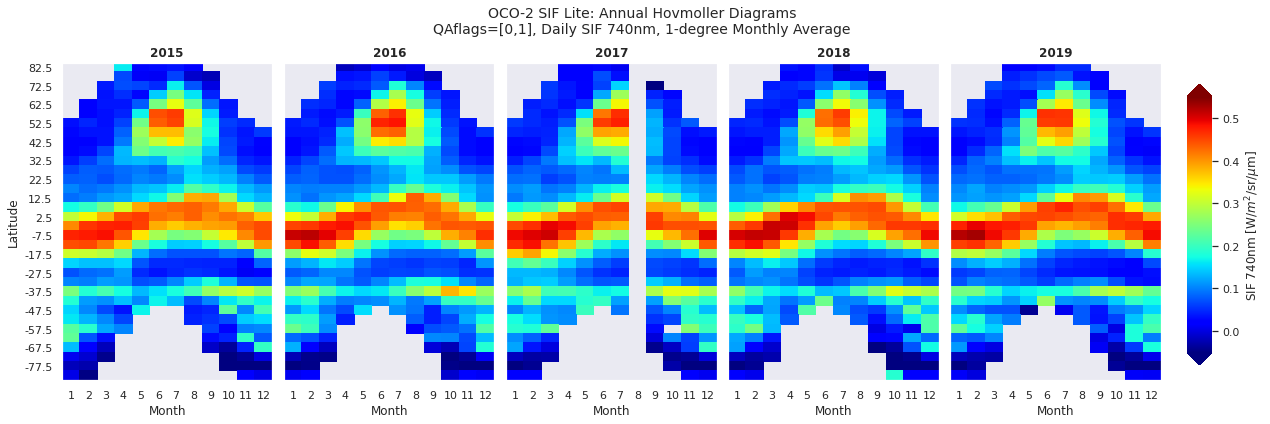

In [12]:
# Figure setup
sns.set_theme()
g = sns.FacetGrid(df, col="year", sharex=False)
plt.gcf().set_size_inches(18, 6) 

# with sns.plotting_context("notebook", font_scale=1.5):
cbar_ax = g.fig.add_axes([.92, 0.15, 0.02, 0.65])
cbar_ax.yaxis.label.set_size(12)
g.map_dataframe(draw_heatmap, "month", "lat", "sif", 
                vmin=-0.05, vmax=0.55,
                cmap="jet", cbar_ax=cbar_ax, 
                cbar_kws={"label": "SIF 740nm [W/$m^2$/sr/$\mu$m]",
                         "extend": "both"})


g.fig.subplots_adjust(top=0.85, right=0.9)
g.fig.suptitle("OCO-2 SIF Lite: Annual Hovmoller Diagrams\n" 
               "QAflags=[0,1], Daily SIF 740nm, 1-degree Monthly Average", 
               size=14)
g.set_titles(col_template="{col_name}", fontweight="bold", fontsize=12)
g.set_axis_labels("Month", "Latitude", fontsize=12)

g.savefig("../plots/sif_lat_hovmoller.png");